In [1087]:
import tensorboard
%load_ext tensorboard
%tensorboard --logdir 'logs/'
import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.preprocessing import KBinsDiscretizer
# Se importan librerías para graficar.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from keras import backend as K
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Input, Dropout
from keras import regularizers
from tensorflow.keras import optimizers
from sklearn.preprocessing import PolynomialFeatures
from keras.regularizers import l2, l1

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 17008), started 1 day, 11:27:59 ago. (Use '!kill 17008' to kill it.)

In [1088]:
df = pd.read_csv('diabetes.csv')

In [1089]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [1090]:
healthy_people_num = (df['Outcome'] == 0).sum()
sick_people_num = (df['Outcome'] != 0).sum()
total = df.shape[0]
print("Healthy people: " + str(healthy_people_num))
print("Sick people: " + str(sick_people_num))
print("Total: " + str(total))

Healthy people: 500
Sick people: 268
Total: 768


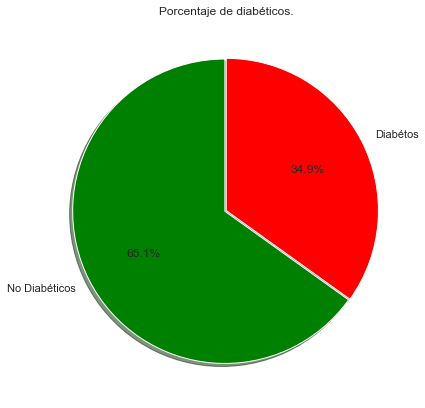

In [1091]:
sns.set(style="whitegrid")
labels = ['No Diabéticos', 'Diabétos']
sizes = [healthy_people_num,sick_people_num]
colors = ["green","red"]
plt.figure(figsize=(7,7))
plt.pie(sizes, labels=labels, explode= (0.01,0) , colors=colors, autopct='%1.1f%%', shadow=True, startangle=90,)

plt.title('Porcentaje de diabéticos.')
plt.show()

In [1092]:
df2 = df.copy()
df2[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df2[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

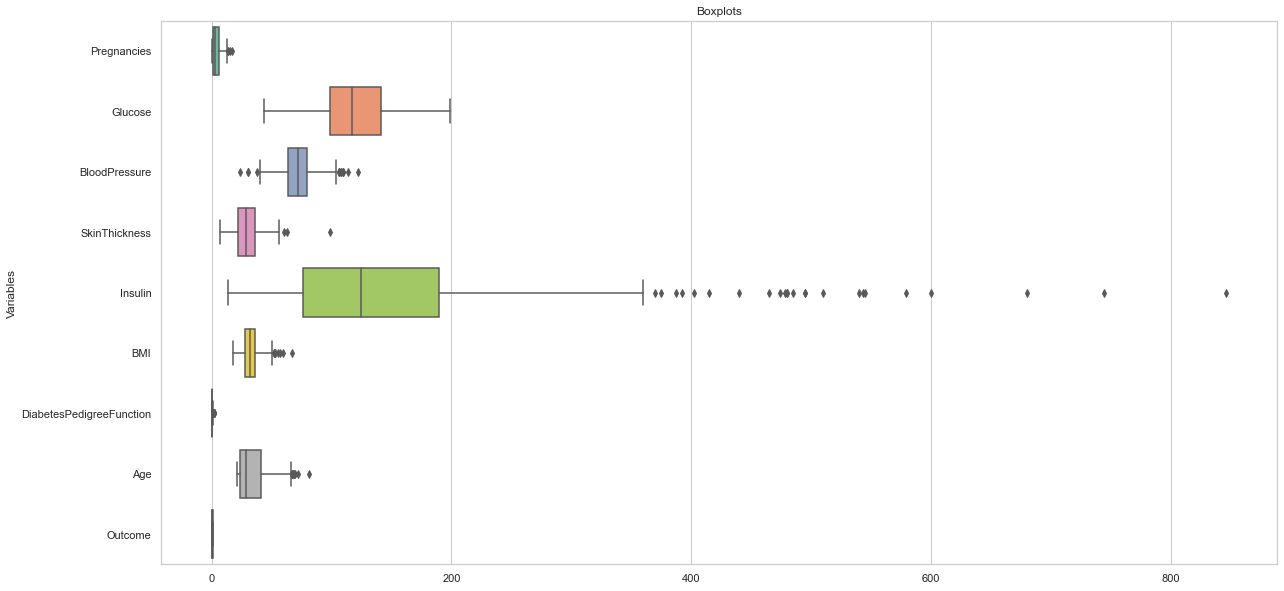

In [1093]:
f, ax = plt.subplots(figsize=(20, 10))
plt.ylabel('Variables')
plt.title("Boxplots")
ax = sns.boxplot(data = df2, 
  orient = 'h', 
  palette = 'Set2')

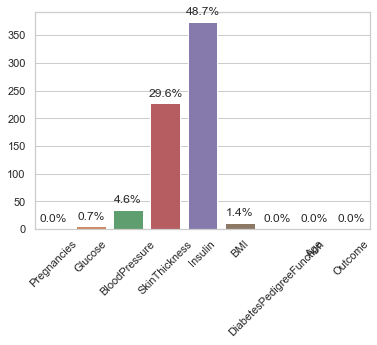

In [1094]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=df2.columns, y=df2.isnull().sum())
plt.xticks(rotation=45);
for p in ax.patches:
    ax.annotate(format(100*p.get_height()/df.shape[0], '.1f') + "%", 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points')

In [1095]:
correlations = df2.corr()
correlations['Outcome'].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.494650
BMI                         0.313680
Insulin                     0.303454
SkinThickness               0.259491
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
BloodPressure               0.170589
Name: Outcome, dtype: float64

In [1096]:
df = df.drop(['Insulin'], axis=1)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,33.6,0.627,50,1
1,1,85,66,29,26.6,0.351,31,0
2,8,183,64,0,23.3,0.672,32,1
3,1,89,66,23,28.1,0.167,21,0
4,0,137,40,35,43.1,2.288,33,1


In [1097]:
np.random.seed(0)
msk = np.random.rand(len(df)) < 0.9
train_val_df = df[msk]
testData = df[~msk]

mskVal = np.random.rand(len(train_val_df)) < 0.9
trainData = train_val_df[mskVal]
validationData = train_val_df[~mskVal]


In [1098]:
 def separate_data_and_labels(df):
        data = df.copy()
        y_values = data[data.columns[-1]].values.reshape(data.shape[0], 1)
        data = data.drop([data.columns[-1]], axis=1)
        return data, y_values

In [1099]:
x_train_data, y_train_values = separate_data_and_labels(trainData)
x_val_data, y_val_values = separate_data_and_labels(validationData)
x_test_data, y_test_values = separate_data_and_labels(testData)

In [1100]:
del(testData)
del(validationData)
del(trainData)
del(df)

In [1101]:
def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())


def negative_predictive_value(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return tn / (tn + fn + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sens_keras = true_positives / (possible_positives + K.epsilon())
    return sens_keras

def positive_predictive_value(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    ppv_keras = true_positives / (predicted_positives + K.epsilon())
    return ppv_keras

In [1102]:
def plot_loss(history):
    # Plot the training loss.
    plt.plot(history.history['loss'], 'r-')

    # Plot the validation loss.
    plt.plot(history.history['val_loss'], 'b-')

    # X-axis label.
    plt.xlabel('Epochs')

    # Y-axis label.
    plt.ylabel('Cost')

    # Graph legend.
    plt.legend(["Training loss", "Validation loss"])

    # Graph title.
    plt.title('Loss Graph')

    plt.show()

In [1103]:
class DiabetesPredictor:
    def __init__(self, name):
        """DiabetesPredictor

    This is a class contains the most part of the methods needed for the diabetes predictor,
    first get the data of the csv file and then perform some methods to clean the data insid
    and allows you to choose if it has to replace outliers or not and replace nulls values or not.

    """
        self.name = name

    def fit(self, train_df, y_train, val_df, y_val, replaceOutliers=False, replaceNulls=False, nullColumns=[], outliersColumnsMap={}, columnsToRemove=[], polyFeatDeg = -1, binsDiscretizer = -1, earlyStop = False, dropOut = False, regu = False, batchNormalization = False):
        train_dataframe = train_df.copy()
        fit_df = train_dataframe.copy()

        self.columnsToRemove = columnsToRemove.copy()
        self.nullCols = nullColumns.copy()
        self.replaceNulls = replaceNulls
        self.replaceOutliers = replaceOutliers
        self.polyFeatDeg = polyFeatDeg
        self.binsDiscretizer = binsDiscretizer
        self.earlyStop = earlyStop
        self.dropOut = dropOut
        self.regu = regu
        self.best_hps = None
        self.batchNormalization = batchNormalization

        self.replace_values_nulls = []
        self.replace_values_outliers = []
        self.outliersLimits = []

        self.nullCols = [n for n in self.nullCols if n not in self.columnsToRemove]
        self.outlierCols = {}
        for k in outliersColumnsMap:
            if k not in self.columnsToRemove:
                self.outlierCols[k] = outliersColumnsMap[k].copy()

        if self.replaceNulls:
            fit_df[self.nullCols] = fit_df[self.nullCols].replace(0,np.NaN)
        ##Parametros##
        self.replace_values_outliers = self.__get_cols_median__(fit_df)
        self.outliersLimits = self.__get_outliers_limits__(fit_df)

        if(self.replaceOutliers):
            fit_df = self.__replace_outliers__(fit_df)

        ##Parametros##
        self.replace_values_nulls = self.__get_cols_median__(fit_df)
        
        if(self.replaceNulls):
            fit_df = self.__replace_nulls__(fit_df)
        
        if (self.polyFeatDeg > 0):
            poly = PolynomialFeatures(degree=self.polyFeatDeg)
            polyArray = poly.fit_transform(fit_df)
            c = poly.get_feature_names(fit_df.columns)
            fit_df = pd.DataFrame(polyArray, columns = c)

        if (self.binsDiscretizer > 1):
            disc = KBinsDiscretizer(n_bins=self.binsDiscretizer, encode='ordinal', strategy='uniform')
            fit_df = disc.fit_transform(fit_df)

        ##Parametros##
        self.mean_cols = self.__get_cols_mean__(fit_df)
        self.std_cols = self.__get_cols_std__(fit_df)

        train_dataframe = self.__preprocess_data__(train_dataframe)
        x_train_values = train_dataframe.values
        y_train_values = y_train.copy()

        self.input_shape = x_train_values.shape

        x_val_df = val_df.copy()
        x_val_df = self.__preprocess_data__(x_val_df)
        x_val_values = x_val_df.values
        y_val_values = y_val.copy()

        self.hypermodel = self.__tune_hyperparams__(x_train_values, y_train_values, x_val_values,y_val_values)

        return self.evaluate(x_val_df, y_val_values, testing = False)
        
    def __preprocess_data__(self, data):
        df = data.copy()
        df = self.__remove_columns__(df)

        if self.replaceNulls:
            df[self.nullCols] = df[self.nullCols].replace(0,np.NaN)

        if(self.replaceOutliers):
            df = self.__replace_outliers__(df)

        if(self.replaceNulls):
            df = self.__replace_nulls__(df)

        if (self.polyFeatDeg > 0):
            poly = PolynomialFeatures(degree=self.polyFeatDeg)
            polyArray = poly.fit_transform(df)
            c = poly.get_feature_names(df.columns)
            df = pd.DataFrame(polyArray, columns = c)

        if (self.binsDiscretizer > 1):
            disc = KBinsDiscretizer(n_bins=self.binsDiscretizer, encode='ordinal', strategy='uniform')
            df = disc.fit_transform(df)

        df = self.__normalize_data__(df)

        return df

    def __get_cols_mean__(self, data):
        meandf = data.mean(axis = 0)
        meandf.columns = data.columns
        return meandf

    def __get_cols_std__(self, data):
        stddf= data.std(axis = 0)
        stddf.columns = data.columns
        return stddf

    def __get_cols_median__(self, data):
        mediandf = data.median(axis = 0)
        mediandf.columns = data.columns
        return mediandf

    def __get_outliers_limits__(self, data):
        df = pd.DataFrame(np.zeros((1,len(data.columns))), columns=data.columns)
        df = df.astype('object')
        for col in data.columns:
            col_min = 0
            col_max = np.Infinity
            if (col in self.outlierCols):
                #Cálculo de parámetros para obtener los outliers.
                q1 = data[col].quantile(0.25)
                q3 = data[col].quantile(0.75)
                iqr = q3-q1
                #Límites de los valores tipicos.
                lower_tail = q1 - 1.5 * iqr
                upper_tail = q3 + 1.5 * iqr

                col_min = min(lower_tail, self.outlierCols[col][0])
                col_max = max(upper_tail,self.outlierCols[col][1])
            lims = [col_min, col_max]
            df[col][0] = lims
        return df

    def __replace_outliers__(self, dataframe):
        #Para cada columna (excepto para el Outcome) se reemplazan los outliers por su mediana.
        df = dataframe.copy()
        for col in df.columns:
            out_min = self.outliersLimits[col][0][0]
            out_max = self.outliersLimits[col][0][1]
            for i in df[col]:
                if i > out_max or i < out_min:
                    df[col] = df[col].replace(i, self.replace_values_outliers[col])
        return df

    def __replace_nulls__(self, dataframe):
        df = dataframe.copy()
        for col in self.nullCols:
            df[col]=df[col].replace(np.NaN, self.replace_values_nulls[col])
        return df

    def __normalize_data__(self, dataframe):
        # Mean, columnar axis.
        df = dataframe.copy()
        for col in df.columns:
            if (self.std_cols[col] != 0):
                df[col] = (df[col] - self.mean_cols[col]) / self.std_cols[col]
            else:
                df[col] = 0
        return df

    def __remove_columns__(self, dataframe):
        df = dataframe.copy()
        df = df.drop(self.columnsToRemove, axis=1)
        return df

    def __model_builder__(self,hp):
        model = Sequential()
        initializer = tf.keras.initializers.GlorotNormal(seed=7)

        if(self.dropOut):
            model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5),input_shape=(self.input_shape[1],)))
            model.add(Dense(1, kernel_initializer=initializer, activation='sigmoid'))
        elif(self.regu):
            reg = reg_wrapper(hp.Choice('type', ['l1', 'l2']), hp.Choice('reg_value', [0.01,0.001,0.1,0.005,0.05]))
            model.add(Dense(1, kernel_initializer=initializer,kernel_regularizer=reg, activation='sigmoid', input_shape=(self.input_shape[1],)))
        elif (self.batchNormalization):
            model.add(BatchNormalization(input_shape=(self.input_shape[1],)))
            model.add(Dense(1, kernel_initializer=initializer, activation='sigmoid'))
        else:
            model.add(Dense(1, kernel_initializer=initializer, activation='sigmoid', input_shape=(self.input_shape[1],)))

        
        # Tune the learning rate for the optimizer
        # Choose an optimal value from 0.01, 0.001, or 0.0001
        #hp_momentum = hp.Choice('momentum',values=[0.9, 0.99, 0.999])
        hp_learning_rate= hp.Float(
            'learning_rate',
            min_value=1e-5,
            max_value=1e-2,
            sampling='LOG',
            default=1e-3
        )
        hp_momentum = hp.Choice('momentum',values=[0.9, 0.99, 0.999])
        hp_decay = hp.Float('decay', 1e-5, 1e-3, sampling='log', default=1e-4)

        model.compile(optimizer=optimizers.SGD(learning_rate=hp_learning_rate, momentum=hp_momentum, decay = hp_decay),
                        loss=keras.losses.BinaryCrossentropy(),
                        metrics=[tf.keras.metrics.AUC()])
        return model

    def __tune_hyperparams__(self, x_train, y_train, x_val, y_val):
        # log_dir = "logs/" + datetime.datetime.now().strftime("%m%d-%H%M")
        # hist_callback = tf.keras.callbacks.TensorBoard(
        #     log_dir=log_dir,
        #     histogram_freq=1,
        #     embeddings_freq=1,
        #     write_graph=True,
        #     update_freq='batch')
        tuner = kt.Hyperband(self.__model_builder__,
                     kt.Objective("val_auc", direction="max"),
                     max_epochs=20,
                     factor=3,
                     seed = 4,
                     executions_per_trial=3,
                     project_name=self.name,
                     directory='saved_models'
                     )
        stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

        #### Search for HyperParams #####
        if (self.earlyStop):
            tuner.search(x_train, y_train, epochs=100, validation_data = (x_val, y_val), callbacks=[stop_early], use_multiprocessing=True, verbose=2)
        else:
            tuner.search(x_train, y_train, epochs=100, validation_data = (x_val, y_val), use_multiprocessing=True, verbose=2)

        # Get the optimal hyperparameters
        self.best_hps = tuner.get_best_hyperparameters()[0]

        # Build the model with the optimal hyperparameters and train it on the data
        model = tuner.hypermodel.build(self.best_hps)
        if (self.earlyStop):
            history = model.fit(x_train, y_train, epochs=100, validation_data = (x_val, y_val),callbacks=[stop_early], verbose=0)
        else:
            history = model.fit(x_train, y_train, epochs=100, validation_data = (x_val, y_val), verbose=0)

        # Plot Loss
        plot_loss(history)

        # Find optimal Epocs
        val_acc_per_epoch = history.history['val_auc']
        best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch))

        # Build and Retrain the model with best Epochs
        hypermodel = tuner.hypermodel.build(self.best_hps)
        if (self.earlyStop):
            hypermodel.fit(x_train, y_train, epochs=best_epoch,callbacks=[stop_early], validation_data = (x_val, y_val), verbose=0)
        else:
            hypermodel.fit(x_train, y_train, epochs=best_epoch, validation_data = (x_val, y_val), verbose=0)

        # Return trained model
        return hypermodel

    def evaluate(self, x_val_df, y_val, testing=True):
        x_df = x_val_df.copy()
        predictions, rounded_preds = self.predict(x_df, testing=testing)

        fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, predictions)
        auc_keras = auc(fpr_keras, tpr_keras)
        spe = specificity(y_val.astype(float),  rounded_preds.astype(float))
        sen = sensitivity(y_val.astype(float),  rounded_preds.astype(float))
        ppv = positive_predictive_value(y_val.astype(float), rounded_preds.astype(float))
        npv = negative_predictive_value(y_val.astype(float), rounded_preds.astype(float))

        self.plot_roc(fpr_keras, tpr_keras, auc_keras)

        print('AUC ' + str(auc_keras))
        print('Specificity: ' + str(spe))
        print('Sensitivity: ' + str(sen))
        print('Positive Predictive Value: ' + str(ppv))
        print('Negative Predictive Value: ' + str(npv))

        return auc_keras, spe, sen, ppv, npv

    def predict(self, x_val_df, testing=True):
        x_df = x_val_df.copy()
        if (testing):
            x_df = self.__preprocess_data__(x_df)
        predictions = self.hypermodel(x_df.values)
        rounded_preds = np.rint(predictions)
        return predictions, rounded_preds

    def plot_roc(self, fpr_keras, tpr_keras, auc_keras):
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_keras, tpr_keras, label=' (Area = {:.3f})'.format(auc_keras))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve ' + self.name)
        plt.legend(loc='best')
        plt.show()
        

In [1104]:
predictor = DiabetesPredictor('predictor')

INFO:tensorflow:Reloading Oracle from existing project saved_models\predictor\oracle.json
INFO:tensorflow:Reloading Tuner from saved_models\predictor\tuner0.json
INFO:tensorflow:Oracle triggered exit


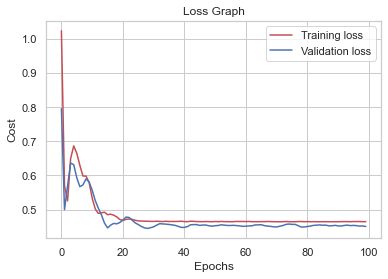

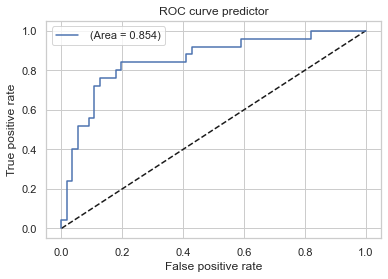

AUC 0.8535714285714286
Specificity: tf.Tensor(0.7321428558354591, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.83999999664, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.583333331712963, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.9111111090864197, shape=(), dtype=float64)


In [1105]:
 aucPred, spePred, senPred, ppvPred, npvPred = predictor.fit(x_train_data, y_train_values, x_val_data, y_val_values)

## Limpiando Datos
#### Reemplazando Nulls por la mediana

INFO:tensorflow:Reloading Oracle from existing project saved_models\rep_nulls_predictor\oracle.json
INFO:tensorflow:Reloading Tuner from saved_models\rep_nulls_predictor\tuner0.json
INFO:tensorflow:Oracle triggered exit


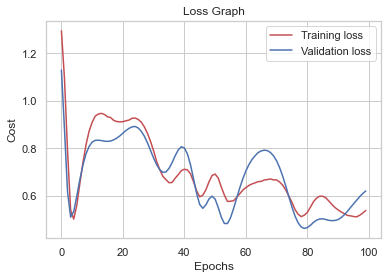

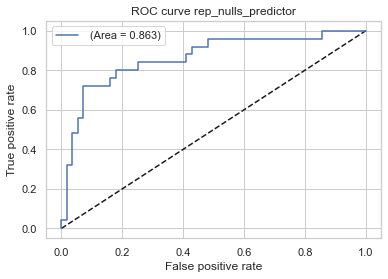

AUC 0.8628571428571428
Specificity: tf.Tensor(0.7499999986607143, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.7999999968, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.5882352923875432, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8936170193752829, shape=(), dtype=float64)


In [1106]:
predictorRepNulls = DiabetesPredictor('rep_nulls_predictor')
aucRepNulls, speRepNulls, senRepNulls, ppvRepNulls, npvRepNulls = predictorRepNulls.fit(x_train_data, y_train_values, x_val_data, y_val_values,replaceNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'])

#### Reemplazando Outliers


INFO:tensorflow:Reloading Oracle from existing project saved_models\rep_outliers_predictor\oracle.json
INFO:tensorflow:Reloading Tuner from saved_models\rep_outliers_predictor\tuner0.json
INFO:tensorflow:Oracle triggered exit


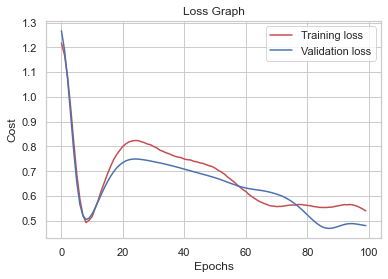

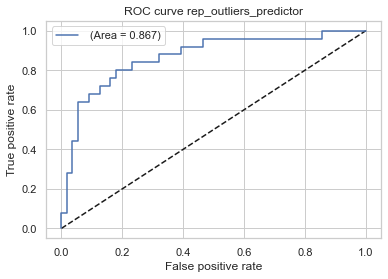

AUC 0.8671428571428571
Specificity: tf.Tensor(0.7321428558354591, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.83999999664, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.583333331712963, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.9111111090864197, shape=(), dtype=float64)


In [1107]:
predictorRepOutliers = DiabetesPredictor('rep_outliers_predictor')
aucRepOut, speRepOut, senRepOut, ppvRepOut, npvRepOut = predictorRepOutliers.fit(x_train_data, y_train_values, x_val_data, y_val_values, replaceOutliers=True, outliersColumnsMap={'BMI': [18.5, 50],'BloodPressure':[40,120],'SkinThickness': [0, np.Infinity], 'Pregnancies': [0, np.Infinity]})

#### Reemplazando Outliers y nulls


INFO:tensorflow:Reloading Oracle from existing project saved_models\rep_outliers_nulls_predictor\oracle.json
INFO:tensorflow:Reloading Tuner from saved_models\rep_outliers_nulls_predictor\tuner0.json
INFO:tensorflow:Oracle triggered exit


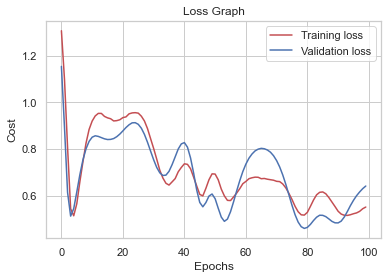

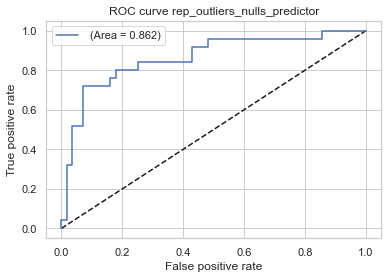

AUC 0.8621428571428571
Specificity: tf.Tensor(0.7499999986607143, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.7999999968, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.5882352923875432, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8936170193752829, shape=(), dtype=float64)


In [1108]:
predictorRepOutliersAndNulls = DiabetesPredictor('rep_outliers_nulls_predictor')
aucRepOutN, speRepOutN, senRepOutN, ppvRepOutN, npvRepOutN = predictorRepOutliersAndNulls.fit(x_train_data, y_train_values, x_val_data, y_val_values,replaceNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'], replaceOutliers=True, outliersColumnsMap={'BMI': [18.5, 50],'BloodPressure':[40,120],'SkinThickness': [0, np.Infinity], 'Pregnancies': [0, np.Infinity]})


#### Removiendo Columnas

Trial 30 Complete [00h 00m 10s]
val_auc: 0.30416667461395264

Best val_auc So Far: 0.867976168791453
Total elapsed time: 00h 03m 35s
INFO:tensorflow:Oracle triggered exit


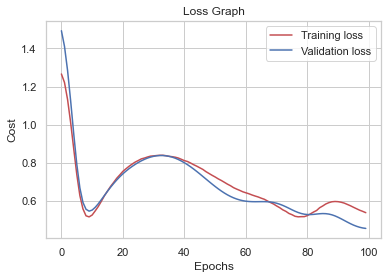

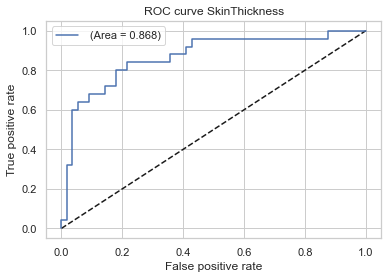

AUC 0.8678571428571429
Specificity: tf.Tensor(0.7678571414859694, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.83999999664, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.6176470570069204, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.9148936150746945, shape=(), dtype=float64)


In [1109]:
bestAuc = aucRepOut
tryRemovingCols = ['BloodPressure', 'Age', 'DiabetesPedigreeFunction', 'Pregnancies', 'SkinThickness']
removeCols = []
removeColsAuc = []
nullCols = ['Glucose','BloodPressure','SkinThickness','BMI']

for col in tryRemovingCols:
	print(col)
	pred = DiabetesPredictor(col)
	aucR, speR, senR, ppvR, npvR = pred.fit(x_train_data, y_train_values, x_val_data, y_val_values, replaceOutliers=True, outliersColumnsMap={'BMI': [18.5, 50],'BloodPressure':[40,120],'SkinThickness': [0, np.Infinity], 'Pregnancies': [0, np.Infinity]}, columnsToRemove=[col])
	if (aucR>bestAuc):
		removeCols.append(col)
		removeColsAuc.append(aucR)



In [1110]:
print(removeCols)
print(removeColsAuc)

['SkinThickness']
[0.8678571428571429]


In [1111]:
# remColsCombPred = DiabetesPredictor('remColsCombPred')
# aucRCCP, speRCCP, senRCCP, ppvRCCP, npvRCCP = remColsCombPred.fit(x_train_data, y_train_values, x_val_data, y_val_values,replaceOutliers=True, outliersColumnsMap={'BMI': [18.5, 50],'BloodPressure':[40,120],'SkinThickness': [0, np.Infinity], 'Pregnancies': [0, np.Infinity]}, columnsToRemove=removeCols)

Trial 4 Complete [00h 00m 05s]
val_auc: 0.20714285969734192

Best val_auc So Far: 0.2633333404858907
Total elapsed time: 00h 00m 24s

Search: Running Trial #5

Hyperparameter    |Value             |Best Value So Far 
learning_rate     |0.0001215         |0.00051785        
momentum          |0.999             |0.99              
decay             |2.3043e-05        |8.8949e-05        
tuner/epochs      |3                 |3                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |2                 |2                 
tuner/round       |0                 |0                 

Epoch 1/3


KeyboardInterrupt: 

#### Sacando solo SkinThickness

Trial 30 Complete [00h 00m 10s]
val_auc: 0.30440476536750793

Best val_auc So Far: 0.8692857225735983
Total elapsed time: 00h 03m 25s
INFO:tensorflow:Oracle triggered exit


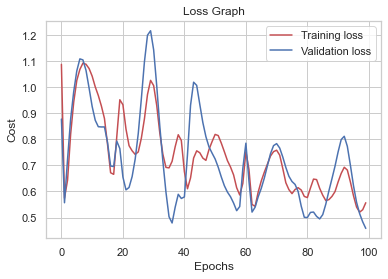

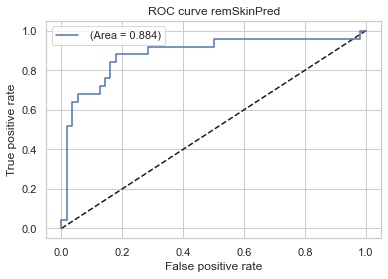

AUC 0.8835714285714286
Specificity: tf.Tensor(0.9642857125637755, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.55999999776, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.87499999453125, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8307692294911243, shape=(), dtype=float64)


In [1115]:
remSkinPred = DiabetesPredictor('remSkinPred')
aucRS, speRS, senRS, ppvRS, npvRS = remSkinPred.fit(x_train_data, y_train_values, x_val_data, y_val_values,replaceOutliers=True, outliersColumnsMap={'BMI': [18.5, 50],'BloodPressure':[40,120], 'Pregnancies': [0, np.Infinity]}, columnsToRemove=["SkinThickness"])


### Con PolynomialFeatures

Trial 30 Complete [00h 00m 10s]
val_auc: 0.86642853418986

Best val_auc So Far: 0.8704761266708374
Total elapsed time: 00h 03m 25s
INFO:tensorflow:Oracle triggered exit


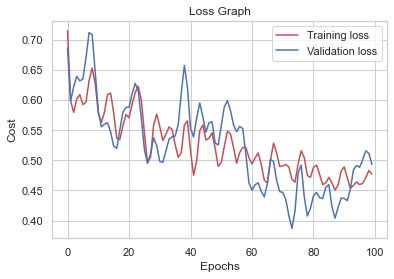

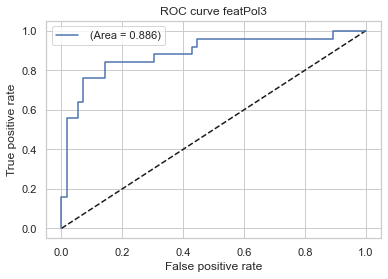

AUC 0.8857142857142858
Specificity: tf.Tensor(0.8392857127869898, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.83999999664, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.6999999976666667, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.9215686256439831, shape=(), dtype=float64)


In [1116]:
aucPolys = []
for i in range(1,4):
    polyPred = DiabetesPredictor('featPol' + str(i))

    aucPoly, spePoly, senPoly, ppvPoly, npvPoly = polyPred.fit(x_train_data, y_train_values, x_val_data, y_val_values,replaceOutliers=True, outliersColumnsMap={'BMI': [18.5, 50],'BloodPressure':[40,120], 'Pregnancies': [0, np.Infinity]}, columnsToRemove=["SkinThickness"], polyFeatDeg = i)
    aucPolys.append(aucPoly)

bestPolDeg = aucPolys.index(max(aucPolys)) + 1


In [1118]:
print(aucPolys)

[0.8642857142857143, 0.8635714285714284, 0.8857142857142858]


In [1117]:
print('Best Degree: ' + str(bestPolDeg) + " --- AUC: " + str(max(aucPolys)))

Best Degree: 3 --- AUC: 0.8857142857142858


#### Con EarlyStopping

Trial 30 Complete [00h 00m 09s]
val_auc: 0.8421428203582764

Best val_auc So Far: 0.8689285516738892
Total elapsed time: 00h 03m 28s
INFO:tensorflow:Oracle triggered exit


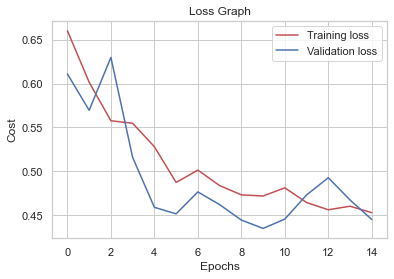

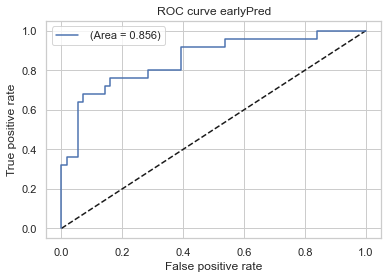

AUC 0.8557142857142858
Specificity: tf.Tensor(0.8392857127869898, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.71999999712, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.6666666641975308, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8703703687585733, shape=(), dtype=float64)


In [1119]:
earlyPred = DiabetesPredictor('earlyPred')
aucEarly, speEarly, senEarly, ppvEarly, npvEarly = earlyPred.fit(x_train_data, y_train_values, x_val_data, y_val_values,replaceOutliers=True, outliersColumnsMap={'BMI': [18.5, 50],'SkinThickness': [0, np.Infinity], 'Pregnancies': [0, np.Infinity]}, columnsToRemove=["BloodPressure"], polyFeatDeg = bestPolDeg, earlyStop = True)

#### Con DropOut

Trial 30 Complete [00h 00m 11s]
val_auc: 0.6572618881861368

Best val_auc So Far: 0.863690455754598
Total elapsed time: 00h 03m 29s
INFO:tensorflow:Oracle triggered exit


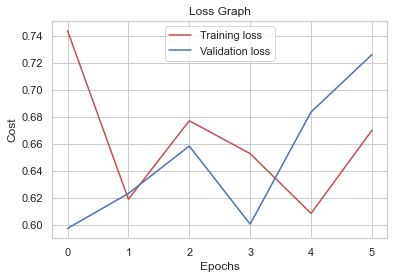

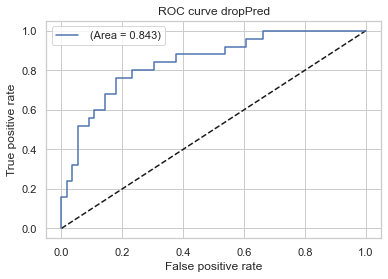

AUC 0.8428571428571429
Specificity: tf.Tensor(0.7678571414859694, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.7999999968, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.6060606042240587, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8958333314670138, shape=(), dtype=float64)


In [1120]:
dropPred = DiabetesPredictor('dropPred')
aucDrop, speDrop, senDrop, ppvDrop, npvDrop = dropPred.fit(x_train_data, y_train_values, x_val_data, y_val_values,replaceOutliers=True, outliersColumnsMap={'BMI': [18.5, 50],'SkinThickness': [0, np.Infinity], 'Pregnancies': [0, np.Infinity]}, columnsToRemove=["BloodPressure"], polyFeatDeg = bestPolDeg, earlyStop = True, dropOut = True)

#### Con Regularizadores

In [1121]:
def reg_wrapper(type, value):
    if type == 'l2':
        return regularizers.l2(value)
    if type == 'l1':
        return regularizers.l1(value)

Trial 30 Complete [00h 00m 08s]
val_auc: 0.8721428513526917

Best val_auc So Far: 0.8721428513526917
Total elapsed time: 00h 03m 34s
INFO:tensorflow:Oracle triggered exit


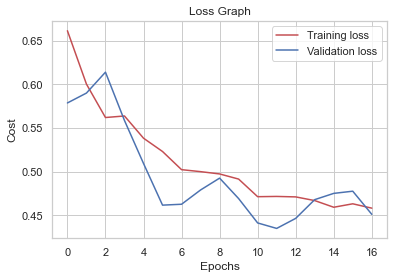

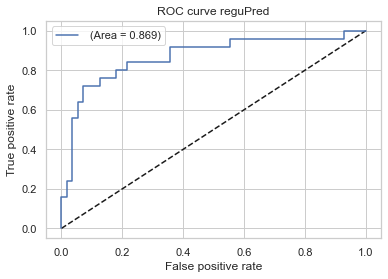

AUC 0.8685714285714285
Specificity: tf.Tensor(0.8392857127869898, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.75999999696, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.6785714261479592, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8867924511569953, shape=(), dtype=float64)


In [1122]:
reguPred = DiabetesPredictor('reguPred')
aucRegu, speRegu, senRegu, ppvRegu, npvRegu = reguPred.fit(x_train_data, y_train_values, x_val_data, y_val_values,replaceOutliers=True, outliersColumnsMap={'BMI': [18.5, 50],'SkinThickness': [0, np.Infinity], 'Pregnancies': [0, np.Infinity]}, columnsToRemove=["BloodPressure"], polyFeatDeg = bestPolDeg, earlyStop = True, regu = True)

In [1123]:
reguPred.best_hps.values

{'type': 'l2',
 'reg_value': 0.005,
 'learning_rate': 0.0030304819108925543,
 'momentum': 0.99,
 'decay': 1.1510936029076842e-05,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

#### Con Batch Normalization

Trial 30 Complete [00h 00m 10s]
val_auc: 0.8421428004900614

Best val_auc So Far: 0.8746428489685059
Total elapsed time: 00h 03m 33s
INFO:tensorflow:Oracle triggered exit


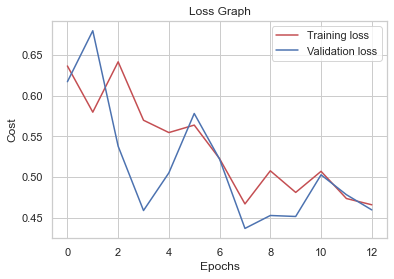

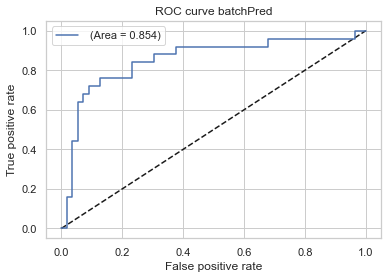

AUC 0.8535714285714285
Specificity: tf.Tensor(0.8749999984375, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.75999999696, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.7307692279585799, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8909090892892562, shape=(), dtype=float64)


In [1124]:
batchPred = DiabetesPredictor('batchPred')
aucBatch, speBatch, senBatch, ppvBatch, npvBatch = batchPred.fit(x_train_data, y_train_values, x_val_data, y_val_values,replaceOutliers=True, outliersColumnsMap={'BMI': [18.5, 50],'SkinThickness': [0, np.Infinity], 'Pregnancies': [0, np.Infinity]}, columnsToRemove=["BloodPressure"], polyFeatDeg = bestPolDeg, earlyStop = True, batchNormalization = True)